# Deep Learning &mdash; Assignment 7

Seventh assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

## Introduction

For this assignment we are doing things a bit different.
* Your task is to reproduce the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks;      Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf).
* Try to follow the experimental settings in that paper, unless there is a reason to deviate.
* If the paper is not clear on some details, make a reasonable choice yourself, and motivate that choice.
* You will have 3 weeks to work on this assignment.
* Be aware that this assignment will take more time than previous ones. It is ok if you do not completely finish it.
* We will *not* be providing you with much code. You will have to implement many things yourself.
* You may freely use code from earlier weeks, and from the d2l books. Please add a comment to reference the original source.
* You may *not* use implementations of the paper you find online.

**Tips and hints**
* It is allowed and recommended to use more than just this notebook. Make separate python files for a library of functions, and for training and analyses.
* If you like working with jupyter notebooks: make a separate notebook for trying things out, and keep this one clean.
* Use checkpoint files before and during training.
* In the notebook only display and discuss these results.
* You may add new cells to this notebook as needed.
* While the task is to reproduce parts of a paper, the big picture is more important than the exact details.
* It is allowed to discuss the assignment with other groups, but try not to spoil too much.
* If you get stuck, contact the teachers via discord.

## Required software

If you need to import any additional libraries, add them below.

In [26]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch
import torch.nn
import torch.nn.utils.prune as prune
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from d2l import torch as d2l
from dl_assignment_7_common import *  # Your functions should go here if you want to use them from scripts

device = d2l.try_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 7.1 The paper (2 points)

**(a) Read sections 1, 2, and 5 of the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks; by Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf)**

We will refer to this as the "LTH paper" from now on, or just "the paper".
To answer some later questions you will also need to look at other sections, and search through the appendices.

**(b) In your own words, briefly explain the key message of the paper.<span style="float:right"> (2 points)</span>**

Note: "briefly" means: a few sentences at most.

The key message of the paper, is that in large neural network there exist smaller subnetwork (called winning tickets) that can be trained in isolation to achieve comparable performance to the original network (or even better) in less epochs. The winning tickets are found with an iterative process of pruning and retraining.

## 7.2 Models and datasets (9 points)

**(a) What neural network architectures are used in the paper?<span style="float:right"> (1 point)</span>**

In the paper the network architectures used are: Lenet, Conv-2, Conv-4, Conv-6, Resnet-18 and VGG-19.

To keep things simple, we will start with a simple architecture, corresponding to what the paper calls `Lenet`.

**(b) Define a function that constructs a `Lenet` network using PyTorch.<span style="float:right"> (2 points)</span>**

Copy these definitions to `dl_assignment_7_common.py`.

Hint: see Figure 2.

Note: the LTH paper is not entirely clear about this, but the convolution layers use `padding='same'`.

In [ ]:
for net_type in ["lenet", "conv2", "conv4", "resnet18", "vgg19"]:
    print(f"{net_type}: {sum(p.numel() for p in create_network(net_type).parameters())} parameters")

**(c) Define a function that can construct a network given the architecture name.**

To keep the code as generic as possible, we can make function

Move the function below to `dl_assignment_7_common.py`, and don't forget to remove it here.

We will do all our experiments with two datasets: MNIST and FashionMNIST

**(d) Are these datasets also used in the papers?<span style="float:right"> (1 point)</span>**

In the paper they use MNIST and CIFAR10, so the dataset FashionMNIST is not used the paper.

**(e) Define a function that loads a dataset given the dataset name.<span style="float:right"> (3 points)</span>**

Hint: Standard datasets such as MNIST and CIFAR10 are available in the [torchvision](https://pytorch.org/vision/stable/datasets.html#image-classification) library.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(f) Most of these datasets come with a predefined train/test split. Is this used in the LTH paper? If so, update the dataset loader to return a pair `(trainset, testset)`.<span style="float:right"> (1 point)</span>**

In the paper they use the predefined train/test split, which is 60000 training images and 10000 test images for MNIST and 50000 training images and 10000 test images for CIFAR10.

**(g) Does the LTH paper use a validation set? If so, update the dataset loader to return `(train_dataset, validation_dataset, test_dataset)`.<span style="float:right"> (1 point)</span>**

Hint: [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split), and/or see assignment 2.

In the paper they have sampled a validation set of 5000 images from the training set.

In [ ]:
for dataset in ["MNIST", "CIFAR10" ,"FashionMNIST"]:
    train_data, validation_data, test_data = get_dataloaders(dataset)
    print(f"{dataset}: {len(train_data.dataset)} training images, {len(validation_data.dataset)} validation images, {len(test_data.dataset)} test images")

## 7.3 Training (12 points)

**(a) What optimization algorithm is used in the paper? What values are used for the hyperparameters?<span style="float:right"> (1.5 points)</span>**

If you are unable to find the values used for some of the hyperparameters, use reasonable default values.

ADAM was used as the optimizer for Lenet and Conv networks, for resnet and VGG SGD with momentum was used. <br/>
They use learning rates $3\cdot 10^{-4}$, $1.2\cdot 10^{-3}$, $2\cdot 10^{-4}$ for Lenet and Conv networks. <br/>
For sgd with momentum they used learning rates 0.1-0.01-0.001 and momentum 0.9


**(b) Implement an evaluation function, that evaluates a model on a validation or test set (passed as an argument).<span style="float:right"> (2 points)</span>**

The function should return loss and accuracy.

Hints: the book defines a function for this that you may use (see assignment 3).

**(c) Implement a training loop.<span style="float:right"> (4 points)</span>**

Make sure that the network parameters are saved to a file before and during training.

Because you will be doing many experiments, it would be a shame to have to re-run them when you reload the notebook. A better solution is to save model checkpoints.
See [the tutorial on saving and loading model parameters](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html) for how to implement this in PyTorch.

**(d) Change the training function so that it saves the model at the start and at the end of training.<span style="float:right"> (1 point)</span>**

Hint: Saving a model requires a filename. Because you will be running many experiments, come up with a descriptive naming convention and/or directory structure. Example: `path = f"checkpoints/model-{arch}-{dataset}-{run}-{phase_of_the_moon}-{iteration}.pth"`.

Hint 2: it is easier to save the whole model, see the bottom of the tutorial.

**(e) Train a simple network on a simple dataset.<span style="float:right"> (1 point)</span>**

You may want to create a new python script (`simple_training.py`), and just load the trained network here instead.

In [ ]:
simple_training_net1, stats1 = load_network("simple_training_1", 0.01, "adam")
print_plot_results(stats1, "simple_training_1")

**(f) Does the training converge? How well does your network perform?<span style="float:right"> (1 point)</span>**

TODO: your answer here.

**(g) Re-train the same network, with the *same* initial weights. Are the results *exactly* the same?<span style="float:right"> (2 points)</span>**

simple_training_2 : train loss 0.064, train acc 0.982, valid loss 0.196, valid acc 0.964, test loss 0.158, test acc 0.970


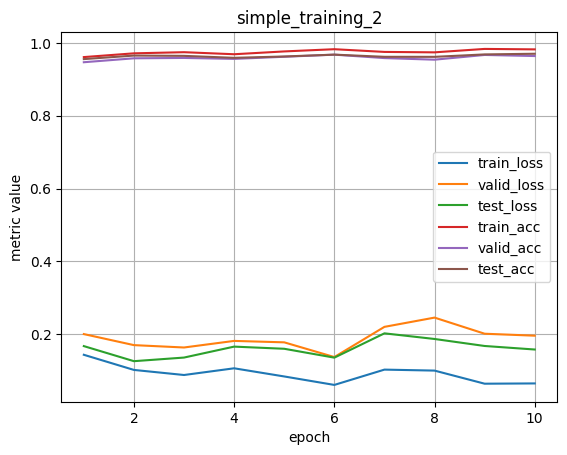

In [28]:
simple_training_net2, stats2 = load_network("simple_training_2", 0.01, "adam")
print_plot_results(stats2, "simple_training_2")

TODO: your answer here.

**(h) The LTH paper uses a variant of 'early-stopping'. How is this done? Implement it in your training loop.<span style="float:right"> (1 point)</span>**

Hint: A simple way to keep track of the best model is to create a model checkpoint in a file `"checkpoints/model-...-best.pth"`.

Hint 2: It is okay to compute the validation scores less often, this can speed up training.

In the paper they use a retroactive variant of early stopping. They train a network for a fixed number of iterations, and then, with the validations performance they select the moment with the best network.

## 7.4 Pruning (13 points)

Next up, you should implement pruning. Starting with the one-shot pruning method.

Hint: 
Pruning is implemented already in PyTorch, in the module [torch.utils.prune](https://pytorch.org/docs/stable/nn.html#module-torch.nn.utils).
The pruning method used in the LTH paper corresponds is called [l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html) in PyTorch.

**(a) The PyTorch pruning function accepts an amount to prune. Is that the amount of weights to set to 0 or the amount to keep nonzero? Is the paper using the same?<span style="float:right"> (1 point)</span>**

The amount in the pytorch pruning function is the amount to set to 0. In the paper they indicate whit p% the amount to prune (like in pytorch) but the result are expressed with Pm which is the percentage of weights remaining.

**(b) Should all parameters be pruned or only weights? Is the pruning rate the same for all types of layers?<span style="float:right"> (1 point)</span>**

Pruning biases can lead to difficulties in training the network effectively, so we should only prune weights (like in the paper). The pruning rate change for different types of layers (for fully connected and convolutional layers), but it does not depend on the layer position (except for the connections to the last layer).

**(c) Define a function to prune a network as used in the LTH paper. It should take an amount to prune as an argument.<span style="float:right"> (3 points)</span>**

Hint: for a `Sequential` layer, you can access the layers as `net.children()`. For a layer, you can use `isinstance(layer, torch.nn.Linear)` to check if it is a linear layer.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`.

**(d) Check your pruning function on a very simple neural network. Print the layer weights before and after pruning to make sure you understand what is going on.<span style="float:right"> (1 point)</span>**

Hint: the PyTorch pruning functions do not change the trainable parameters, rather they set `module.weight` to `weight_orig * weight_mask`.

In [ ]:
for net_type in ["lenet", "conv2", "conv4", "resnet18", "vgg19"]:
    net = create_network(net_type)
    params_before = sum(p.numel() for p in net.parameters())
    prune_network(net, net_type, 0.5)
    params_after = params_before - sum(torch.sum(b == 0) for b in net.buffers()).item()
    print("Net: " + net_type + " Before pruning: " + str(params_before) + " After pruning: " + str(params_after) +
          " Pruned: " + str(round(abs(1-(params_after / params_before))*100, 2)))

In [ ]:
net_type = "lenet"
net = create_network(net_type)
print("Before: " + str(list(net.children())[0].weight))
prune_network(net, net_type, 0.2)
print("After: " + str(list(net.children())[0].weight))

In [ ]:
print(sum(torch.sum(b == 0) for b in net.buffers()).item())

**(e) Define a function that applies the pruning mask from a pruned network to another network of the same architecture.<span style="float:right"> (2 points)</span>**

This function should only do pruning (so some weights become 0), other weights should remain the same.

Hint: the pruning functions already generate and store pruning masks. You should be able to extract these from a pruned network.

Hint 2: `custom_from_mask`

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(f) Check your mask copy function on a very simple neural network. Check that only the pruning mask is copied.<span style="float:right"> (1 point)</span>**

In [24]:
net_type = "lenet"
net_in = create_network(net_type)
prune_network(net_in, net_type, 0.3)

net_out = create_network(net_type)
print("Before: " + str(list(net_out.children())[0].weight))
params_before = sum(p.numel() for p in net.parameters())

prune_network_from_mask(net_in, net_out)
params_after = params_before - sum(torch.sum(b == 0) for b in net_out.buffers()).item()
print("After: " + str(list(net_out.children())[0].weight))

print("Before pruning: " + str(params_before) + " After pruning: " + str(params_after) +
      " Pruned: " + str(round(abs(1-(params_after / params_before))*100, 2)))

Before: Parameter containing:
tensor([[ 0.0125, -0.0194, -0.0312,  ...,  0.0146, -0.0001, -0.0066],
        [ 0.0164, -0.0259, -0.0189,  ...,  0.0150,  0.0200, -0.0025],
        [ 0.0348, -0.0207, -0.0067,  ..., -0.0103,  0.0059,  0.0018],
        ...,
        [-0.0031,  0.0022,  0.0263,  ...,  0.0302, -0.0277,  0.0264],
        [-0.0224,  0.0228,  0.0232,  ...,  0.0139,  0.0307,  0.0317],
        [ 0.0260,  0.0111,  0.0330,  ..., -0.0054,  0.0175, -0.0156]],
       requires_grad=True)
After: tensor([[ 0.0000, -0.0194, -0.0000,  ...,  0.0146, -0.0001, -0.0000],
        [ 0.0000, -0.0259, -0.0189,  ...,  0.0150,  0.0000, -0.0025],
        [ 0.0348, -0.0207, -0.0067,  ..., -0.0103,  0.0059,  0.0000],
        ...,
        [-0.0031,  0.0022,  0.0263,  ...,  0.0000, -0.0277,  0.0000],
        [-0.0000,  0.0228,  0.0000,  ...,  0.0139,  0.0000,  0.0317],
        [ 0.0000,  0.0111,  0.0000,  ..., -0.0054,  0.0000, -0.0156]],
       grad_fn=<MulBackward0>)
Before pruning: 266610 After pruning:

In [27]:
get_pruned_params(net_out, params_before)

0.3

In [ ]:
list(net_out.named_parameters())

**(g) Define a function that randomly prunes a network.<span style="float:right"> (1 point)</span>**

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(h) Check the above function.<span style="float:right"> (1 point)</span>**

In [ ]:
for net_type in ["lenet", "conv2", "conv4", "resnet18", "vgg19"]:
    net = create_network(net_type)
    params_before = sum(p.numel() for p in net.parameters())
    prune_network(net, net_type, 0.2, prune_type=prune.RandomUnstructured)
    params_after = params_before - sum(torch.sum(b == 0) for b in net.buffers()).item()
    print("Net: " + net_type + " Before pruning: " + str(params_before) + " After pruning: " + str(params_after) +
          " Pruned: " + str(round(abs(1-(params_after / params_before))*100, 2)))

**(i) Define a function that performs the experiment described in Section 1 of the LTH paper on a given dataset and with a given architecture.<span style="float:right"> (2 points)</span>**

Save all needed results to a file, such as test loss and accuracy. This will make your job easier later on.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

## 7.5 Confirming the Lottery Ticket Hypothesis (10 points)

**(a) Perform the experiments needed to reproduce the red lines in Figure 1 from the LTH paper.<span style="float:right"> (6 points)</span>**

* It is ok to ignore the error bars for now, and focus on doing one series of experiments.
* You may also reduce the number of points in the plot to keep the computation time managable.
* You do not have to match the visual style of the figure.

Hint: create a python script (`experiment1-{dataset}-{method}.py`) that does all the training as needed.
Then load the checkpoint files and do your analysis here.
You may also want to define more helper functions.

Hint 2: look at previous assignments for how to plot. If you do want to include error bars, see also [documentation for `plt.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html).

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(b) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

TODO: your answer here.

**(c) What can you conclude from this experiment?<span style="float:right"> (2 points)</span>**

TODO: your answer here.

## 7.6 Experiments from Section 2 (12 points)

**(a) What is the difference between the experiment in Figure 1 and Figure 3 of the paper.<span style="float:right"> (1 point)</span>**

Hint: are there differences in the method, the architecture, or the dataset?

TODO: your answer here.

**(b) Implement the iterative pruning method from the paper.<span style="float:right"> (3 points)</span>**

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(c) Perform the experiments needed to reproduce Figure 4a from the paper.<span style="float:right"> (4 points)</span>**

Hint: see previous section

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

In [ ]:
def iterative_pruning_training(net, net_type, datasets, experiment_folder_name, save_path="checkpoints", reinit=False, pruning_amount=0.2, pruning_target=0.01, conv_amount=None, out_amount=None, prune_type=prune.L1Unstructured, **training_kwargs):

    path = os.path.join(os.getcwd(), save_path, f"{experiment_folder_name}")
    if not os.path.exists(path) or os.listdir(path) == []:
        if not os.path.exists(path):
            os.mkdir(path)

    if training_kwargs.get("epochs") is None:
        training_kwargs["epochs"] = get_num_epochs(net_type)

    total_params = sum(p.numel() for p in net.parameters())
    trained_net, stats = train(net, datasets, "100", save_path=path,**training_kwargs)
    prune_network(net, net_type, pruning_amount, prune_type=prune_type, conv_amount=conv_amount, out_amount=out_amount)
    pruned_params = get_pruned_params(trained_net, total_params)

    while (1 - pruned_params) > pruning_target:
        net_name = str(int((1 - pruned_params) * 100)).zfill(3) # makes the name of the network the percentage of weights remaining
        trained_net, stats = train(trained_net, datasets, net_name, save_path=path, **training_kwargs)
        prune_network(net, net_type, pruning_amount, prune_type=prune_type, conv_amount=conv_amount, out_amount=out_amount)
        pruned_params = get_pruned_params(trained_net, total_params)

#todo test e tutto

In [ ]:
sorted(['010', '100', '020', '001']) # todo implementa il ripristino (forse)

In [ ]:
create_lenet(28).state_dict()

**(d) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

In [50]:
(np.argmax(pd.read_csv("epoch_stats.csv", index_col="epoch")["valid_acc"][2-1::2])+1) * 2

16

TODO: your answer here.

**(e) What can you conclude from this experiment?<span style="float:right"> (2 points)</span>**

TODO: your answer here.

## 7.7 Experiments from Section 4 (7 points)

Section 3 and 4 deal with convolutional neural networks. We are going to skip the networks in section 3, and move on to Figure 8.

**(a) Section 4 of the paper describes a slightly different pruning method. Implement that method.<span style="float:right"> (2 points)</span>**

Hint: look at [`torch.nn.utils.prune.global_unstructured`](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.global_unstructured.html) and at the examples on that page.

If you get stuck on this step, you can continue with the same pruning methods as before.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(b) Implement a function that constructs the network architecture used in Figure 8.<span style="float:right"> (1 point)</span>**

Extend the `create_network` function defined earlier.

Hint: VGG16 and Resnet18 are [predefined in torchvision](https://pytorch.org/vision/0.12/models.html).

**(c) Perform the experiments needed to reproduce Figure 8 from the LTH paper.<span style="float:right"> (2 points)</span>**

* Again: you do not need to include error bars.
* You may limit yourself to one of the figures.

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(d) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

TODO: your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 65 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 97b3d19 / 2023-10-19</span>